In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import RK4
import pickle
import time
from scipy.interpolate import NearestNDInterpolator

In [3]:
with open('potential_grid.plk', 'rb') as f:
    potential_grid = pickle.load(f)
    
m_and_c_output = pd.read_table('mandcoutput.txt', skiprows=1, header=None, delimiter='  ')
m_and_c = m_and_c_output[[0, 1, 2, 16]].rename(columns={0: 'z', 1: 'halo_mass', 2: 'c', 16: 'universe_age'})

r_values = np.logspace(0, 4, 1001, endpoint=1)
z_values = m_and_c.loc[m_and_c.z < 10].z.index

coords = np.vstack(map(np.ravel, np.meshgrid(r_values, z_values))).T
values = np.ravel(potential_grid.T.values)

potential_interpolator = NearestNDInterpolator(coords, values)

def get_potential(R, z):
    return potential_interpolator.__call__(R, z)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


### initial samples

drawn from suitable physical range

In [4]:
r_max = 100
n_r = 5
r_bins = [1 + r_max * (i/n_r) ** 2 for i in range(n_r + 1)]

# p_max = 0.005 * (1 + m_and_c.loc[m_and_c.z < 10].z.max())  * 8e-53 / 1e-67
p_max = 1.5e3  # total guess; 30000kpc / 20z --> 1.5e3 --> enough to traverse the entire 30 Mpc range twice?
n_p = 10
p_bins = [p_max * (j / n_p) ** 2 for j  in range(n_p + 1)]

alpha = 2.
theta_bins = [np.pi / 2 * (k / 10) ** alpha for k in range(10 + 1)] + [np.pi - np.pi / 2 * ((k - 10) / 10) ** alpha for k in range(10, 20)]

### time evolution of samples

treat redshift (z) as time

In [23]:
results_small_r = pd.DataFrame()
for r in r_bins[:50]:
    for p in p_bins:
        for theta in theta_bins:
            L = r * p * np.sin(theta)
            dr_dt = lambda t, x: [x[1], 0]  # x = [r, v]
            dv_dt = lambda t, x: [0, L ** 2 / np.abs(x[0]) ** 3 - np.sign(x[0]) * get_potential(np.abs(x[0]), t)]  # x = [r, v]
            integrator = RK4.RK4([dr_dt, dv_dt])
            orbit = integrator.integrate([r, p], t0=10, tf=0.4, steps=1000)
            results_small_r = results_small_r.append({'r': r, 'p': p, 'theta': theta, 'final_position': orbit[1][0][-1]}, ignore_index=True)


# results.to_csv('results.csv')
# results_small_r.to_csv('results_small_r.csv')

### final density profile

In [9]:
from scipy.integrate import quad

def r_contribution(r_value):
    
    i = r_bins.index(r_value)
    try:
        return (r_bins[i + 1] ** 3 - r_bins[i] ** 3) / 3
    except IndexError:
        return np.nan

def p_contribution(p_value):
    
    j = p_bins.index(p_value)
    
    try:
        p_j = p_bins[j] * 1e-67 / 8e-53
        p_j_plus_1 = p_bins[j + 1] * 1e-67 / 8e-53
    except IndexError:
        return np.nan
    
    k_boltzmann = 8.62e-5 # eV * K^-1
    T_v = 1.9 # K
    
    integrand = lambda p: p ** 2 / (np.exp(p / (k_boltzmann * T_v)) + 1)
    
    return quad(integrand, p_j, p_j_plus_1)[0]

def theta_contribution(theta_value):
    
    k = theta_bins.index(theta_value)
    
    try:
        return np.abs(np.cos(theta_bins[k + 1]) - np.cos(theta_bins[k]))
    except IndexError:
        return np.nan

In [615]:
all_results = results.append(results_small_r, ignore_index=True)

all_results['r_contribution'] = all_results.apply(lambda x: r_contribution(x.r), axis=1)
all_results['p_contribution'] = all_results.apply(lambda x: p_contribution(x.p), axis=1)
all_results['theta_contribution'] = all_results.apply(lambda x: theta_contribution(x.theta), axis=1)

all_results['weight'] = all_results['r_contribution'] * all_results['p_contribution'] * all_results['theta_contribution']

all_results['r_final_bins'] = pd.cut(all_results.final_position, np.logspace(1, 4))

total_mass = all_results.groupby('r_final_bins')[['weight']].sum().cumsum()
total_mass = total_mass.rename(columns={'weight': 'total_mass'})

all_with_mass = pd.merge(all_results, total_mass, how='left', on='r_final_bins')

all_with_mass['density'] = all_with_mass['total_mass'] / (all_with_mass['r'] ** 3)

NameError: name 'results' is not defined

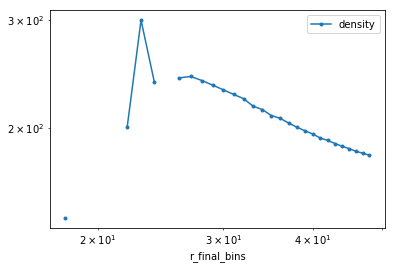

In [163]:
(all_with_mass.groupby('r_final_bins')[['density']].min().clip(upper=3e-15) / 1e-17).plot(loglog=True, marker='.')
plt.show()

#### -->not resolving well over whole range. need more samples, but efficiency of integrator is limiting granularity

### same time evolution process but using adaptive integrator

In [683]:
importlib.reload(RK4)

<module 'RK4' from '/Users/andrewmadigan/Documents/summer research 17/RK4.py'>

In [1]:
results_small_r_3 = pd.DataFrame()
t0 = time.time()
for r in r_bins:
    print(f'r={r}, time={time.time() - t0}')
    for p in p_bins:
        for theta in theta_bins:
            L = r * p * np.sin(theta)
            dr_dt = lambda t, x: [x[1], 0]  # x = [r, v]
            dv_dt = lambda t, x: [0, L ** 2 / x[0] ** 3 - np.sign(x[0]) * get_potential(np.abs(x[0]), t)]  # x = [r, v]
            integrator = RK4.RK4([dr_dt, dv_dt])
            # if t0 < tf, min_step_size must be 
            orbit = integrator.integrate_adaptive([r, p * np.cos(theta)], t0=10., tf=0.4, tolerance=1e-7, min_step_size=-0.000001)
            results_small_r_3 = results_small_r_3.append({'r': r, 'p': p, 'theta': theta, 'final_position': orbit[1][0][-1]}, ignore_index=True)
print('total time:', time.time() - t0)

In [38]:
results_small_r_3.to_csv('small_r_100.csv')
# results_small_r_3 = pd.read_csv('small_r_100.csv')
# results_small_r_3 = results_small_r_3.astype({'r':'int', 'p': 'int'})

results_small_r_2.to_csv('r_3e4.csv')
# results_small_r_2 = pd.read_csv('r_3e4.csv')
# results_small_r_2 = results_small_r_2.astype({'r':'int', 'p': 'int'})

# r_bins = list(results_small_r_2.r.unique())
# p_bins = list(results_small_r_2.p.unique())
# theta_bins = list(results_small_r_2.theta.unique())

In [7]:
pd.options.mode.chained_assignment = None

In [79]:
all_results = results_small_r_2.loc[np.abs(results_small_r_2.final_position) < 3e4]
all_results.r = np.abs(all_results.r)

all_results['r_contribution'] = all_results.apply(lambda x: r_contribution(x.r), axis=1)
all_results['p_contribution'] = all_results.apply(lambda x: p_contribution(x.p), axis=1)
all_results['theta_contribution'] = all_results.apply(lambda x: theta_contribution(x.theta), axis=1)

all_results['weight'] = all_results['r_contribution'] * all_results['p_contribution'] * all_results['theta_contribution']

all_results['r_final_bins'] = pd.cut(all_results.final_position, np.logspace(1, 5, 100))

total_mass = all_results.groupby('r_final_bins')[['weight']].sum().cumsum()
total_mass = total_mass.rename(columns={'weight': 'total_mass'})

all_with_mass = pd.merge(all_results, total_mass, how='left', on='r_final_bins')

all_with_mass['density'] = all_with_mass['total_mass'] / (np.abs(all_with_mass['final_position']) ** 3)

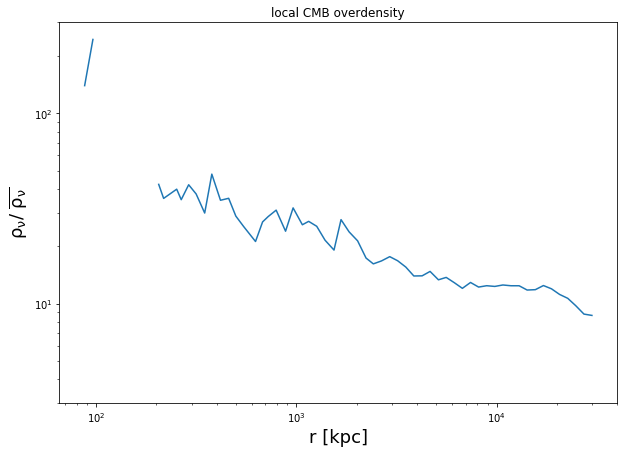

In [80]:
plt.loglog(all_with_mass.groupby('r_final_bins')[['final_position']].min(), all_with_mass.groupby('r_final_bins')[['density']].min() / 1e-37)
plt.ylim(3e0, 3e2)
plt.xlabel('r [kpc]', fontsize=18)
plt.ylabel('$\mathregular{ρ_ν} / $ $\mathregular{\overline{ρ_ν}}$', fontsize=18)
plt.title('local CMB overdensity')
plt.show()

#### better resolution over range.  need to parallelize and run over many more samples to resolve r < $10^2$